# TOLIMAN Image Simulation

This is a variation on Ben's [toy model](poppy_toliman_doubly_diffractive.ipynb), using the [`poppy`](http://pythonhosted.org/poppy/) package to simulate the image collected by the TOLIMAN CCD inclusive of noise.

## Architecture and noise sources

We're assuming a folded Gregorian/Cassegrain telescope with a special concave primary mirror containing a rosette of elliptical diffraction gratings. 

Element | Noise
--- | ---
Object ($\alpha$ Cent A and B) | Stellar Variability (spectral, morphological), pointing stability
Primary Mirror (paraboloid f/4, D=300mm)| Intrinsic Aberrations, Thermal distortions
Secondary Mirror | Intrinsic Aberrations, Thermal distortions
Struts for secondary mirror (5-leg spider) |
Bandpass filter ($\lambda=650$nm, $\Delta\lambda=50$nm) | 
CCD (GSENSE400 CMOS) | Dark Current, Pixel Non-Uniformity, Shot Noise

In [ ]:
import poppy
import numpy as np
from astropy import *
from astropy.table import Table

from __future__ import (absolute_import, division, print_function, unicode_literals)
import scipy.special
import scipy.ndimage.interpolation
import matplotlib
import astropy.io.fits as fits
import warnings

import pysynphot as S

%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 200             #72 

import logging
logging.getLogger('poppy').setLevel(logging.WARN)

Populating the interactive namespace from numpy and matplotlib


## Define a custom aperture for TOLIMAN

We want to have a non-centro-symmetric rosette of ellipses for TOLIMAN in order to avoid extensive nulls. We therefore need to define both an elliptical aperture, and a composite aperture which sums individual subapertures.

In [2]:
import toliman_optics
rosette = toliman_optics.rosette(
        5, # 5-fold rotational symmetry
        0.3, # 30 cm 
        0.8, 
        0.065 # 6.5 cm semimajor
    )
rosette.name = 'TOLIMAN'

(<matplotlib.axes._subplots.AxesSubplot at 0x7f283178e5c0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f282d91ef28>)

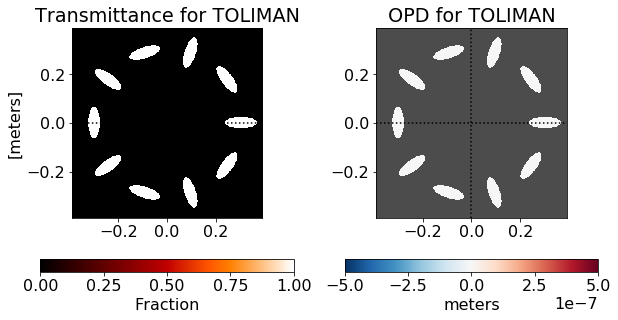

In [3]:
values = rosette.sample(npix=2048)    # evaluate on 512 x 512 grid

plt.figure(figsize=(10,5))
rosette.display(what='both')         # display phase and amplitude transmission;

## What does the PSF look like?

$D$ = 300mm
EFL = 15m (f/50)
CCD 2048x2048 11$\mu$m pixels = 22.5mmx22.5mm
Field of view 5.16'x5.16' = 310"x310"

Each pixel covers 310"/2048 = 0.15"

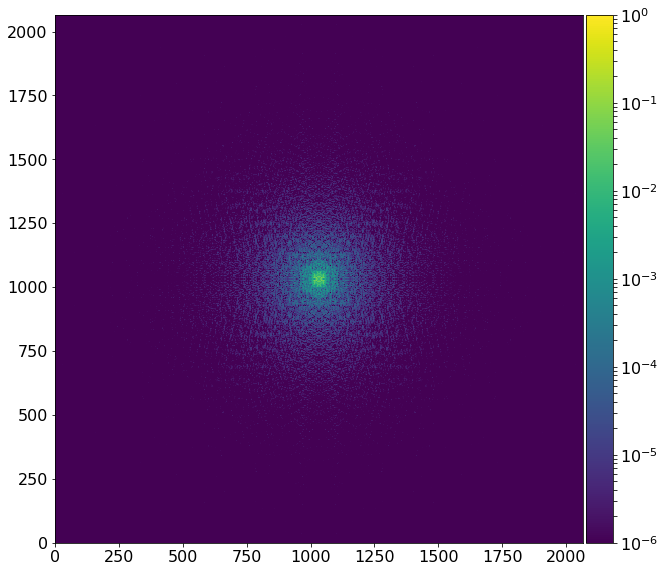

In [4]:
osys = poppy.OpticalSystem()
osys.add_pupil(rosette)    # pupil radius in meters

# I get double the detector size when I use correct pixelscale and FOV. Halve FOV (assuming it's the half-angle)
osys.add_detector(pixelscale=0.15, fov_arcsec=155.)  # image plane coordinates in arcseconds
wavelength=650e-9
psf = osys.calc_psf(wavelength)                            # wavelength in microns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm

ax = plt.gca()


# im = poppy.display_psf(psf, title='Mock PSF',normalize='peak')
data = psf[0].data/psf[0].data.max()
im = plt.imshow(data,norm=LogNorm(vmin=1e-6, vmax=1))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
plt.savefig('psf_650nm_50nmbpass_tight.png',bbox_inches='tight', pad_inches=0)

In [5]:
psf[0].data

array([[  9.64939888e-10,   1.33146074e-09,   7.24918785e-10, ...,
          7.24918785e-10,   1.33146074e-09,   9.64939888e-10],
       [  5.18552634e-09,   3.73155480e-09,   1.48924763e-09, ...,
          1.48924763e-09,   3.73155480e-09,   5.18552634e-09],
       [  5.00003603e-09,   2.21593409e-09,   1.57409904e-10, ...,
          1.57409904e-10,   2.21593409e-09,   5.00003603e-09],
       ..., 
       [  5.00003603e-09,   2.21593409e-09,   1.57409904e-10, ...,
          1.57409904e-10,   2.21593409e-09,   5.00003603e-09],
       [  5.18552634e-09,   3.73155480e-09,   1.48924763e-09, ...,
          1.48924763e-09,   3.73155480e-09,   5.18552634e-09],
       [  9.64939888e-10,   1.33146074e-09,   7.24918785e-10, ...,
          7.24918785e-10,   1.33146074e-09,   9.64939888e-10]])

In [10]:
# use Phoenix models for Teff, metallicity (dex), log g in that order 
# alpha cen A: Teff = 5790, Z = 0.20, log g = 4.30
acenA = S.Icat('phoenix',5790,0.2,4.30)

# alpha cen B: Teff = 5260, Z = 0.23, log g = 4.37
acenB = S.Icat('phoenix',5260,0.23,4.37)

In [11]:
centre_wavel = 6500
fwhm = 500

# bp = S.ObsBandpass('wfc3,uvis1,f621m')


In [12]:
def supergaussian(wavels,centre,sigma=10,n=8):
    return np.exp(-((wavels-centre)/(sigma/2.))**n)

In [13]:
wavels = np.linspace(centre_wavel-0.75*fwhm,centre_wavel+0.75*fwhm,50)
# bandpass = bp.sample(wavels)
bandpass = supergaussian(wavels,centre_wavel,sigma=fwhm)
specA = acenA.sample(wavels)
specB = acenB.sample(wavels)

source = {'wavelengths':wavels*1e-10,
          'weights':specA*bandpass}

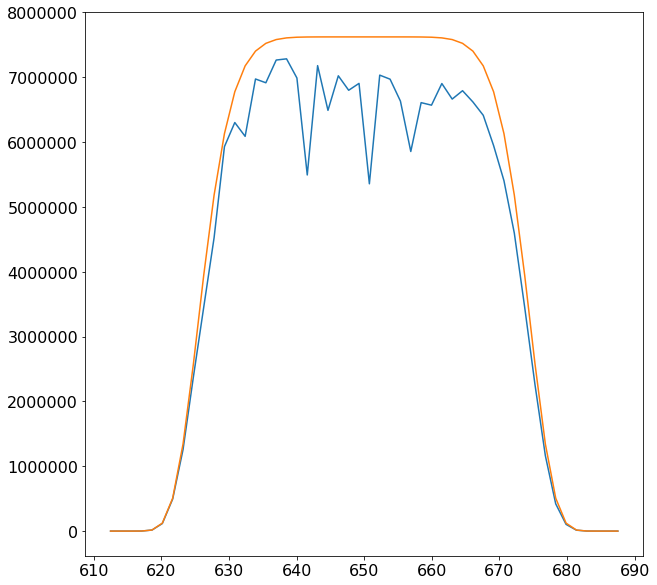

In [14]:
plt.plot(wavels/10.,specA*bandpass)
plt.plot(wavels/10.,np.max(specA)*bandpass)